In [1]:
# Import packages
import tensorflow as tf
import numpy as np
import PIL
from PIL import Image
import os
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *


In [2]:
# load images

## training
training_images_list = os.listdir("./data/training/images/")
training_masks_list = []
training_images = []
for n in training_images_list:
  im = PIL.Image.open(r"./data/training/images/{}".format(n))
  training_images.append(im)
  training_masks_list.append(n[:-5]+'.png')

## trainging masks
training_masks = []
for n in training_masks_list:
  im = PIL.Image.open(r"./data/training/masks/{}".format(n))
  training_masks.append(im)

## validation
validation_images_list = os.listdir("./data/validation/images/")
validation_masks_list = []
validation_images = []
for n in validation_images_list:
  im = PIL.Image.open(r"./data/validation/images/{}".format(n))
  validation_images.append(im)
  validation_masks_list.append(n[:-5]+'.png')

## validation masks
validation_masks = []
for n in validation_masks_list:
  im = PIL.Image.open(r"./data/validation/masks/{}".format(n))
  validation_masks.append(im)

## testing
test_images_list = os.listdir("./data/test/")
test_images = []
for n in test_images_list:
  im = PIL.Image.open(r"./data/test/{}".format(n))
  test_images.append(im)


In [3]:
for i in range(len(training_images)):
  training_images[i] = np.array(training_images[i])/255
  training_images[i] = training_images[i].reshape(512,512,3)
  training_images[i] = training_images[i].astype('float32')

for i in range(len(training_masks)):
  training_masks[i] = (np.array(training_masks[i])-1)
  training_masks[i] = training_masks[i][:512,:512]
  training_masks[i] = training_masks[i].reshape(512,512,1)
  training_masks[i] = training_masks[i].astype('int')

for i in range(len(validation_images)):
  validation_images[i] = np.array(validation_images[i])/255
  validation_images[i] = validation_images[i].reshape(1,512,512,3)
  validation_images[i] = validation_images[i].astype('float32')

for i in range(len(validation_masks)):
  validation_masks[i] = np.array(validation_masks[i])-1
  validation_masks[i] = validation_masks[i][:512,:512]
  validation_masks[i] = validation_masks[i].reshape(1,512,512,1)
  validation_masks[i] = validation_masks[i].astype('int')

for i in range(len(test_images)):
  test_images[i] = np.array(test_images[i])/255
  test_images[i] = test_images[i].reshape(1,512,512,3)
  test_images[i] = test_images[i].astype('float32')

for i in range(75,90):
  validation_images.append(training_images[i])
  validation_masks.append(training_masks[i])

training_images = training_images[0:75]
training_masks = training_masks[0:75]

In [4]:
training_images = np.array(training_images)
training_masks = np.array(training_masks)

validation_images = np.array(validation_images)
validation_masks = np.array(validation_masks)

C:\Users\radum\AppData\Local\Temp\ipykernel_16096\4161211130.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  validation_images = np.array(validation_images)
C:\Users\radum\AppData\Local\Temp\ipykernel_16096\4161211130.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  validation_masks = np.array(validation_masks)


### Custom model

In [5]:
input_shape = (512, 512, 3)

inputs = Input(input_shape)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
up1 = UpSampling2D((2, 2))(conv3)
concat1 = Concatenate()([up1, conv2])
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat1)
up2 = UpSampling2D((2, 2))(conv4)
concat2 = Concatenate()([up2, conv1])
outputs = Conv2D(1, (1, 1), activation='sigmoid')(concat2)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 256, 256, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [6]:
# model.fit(training_images, training_masks, epochs=10, batch_size=8)

# model.save('models/custom-model/model')
saved_model = tf.keras.models.load_model('models/custom-model/model')
saved_model.summary()

metrics = saved_model.evaluate(np.asarray(validation_images[0]), np.asarray(validation_masks[0]), batch_size=4)

print('Validation loss:', metrics[0])
print('Validation accuracy:', metrics[1])

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 512, 512, 32  896         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 256, 256, 32  0          ['conv2d_20[0][0]']              
                                )                                                           

1/1 [==============================] - 0s 260ms/step


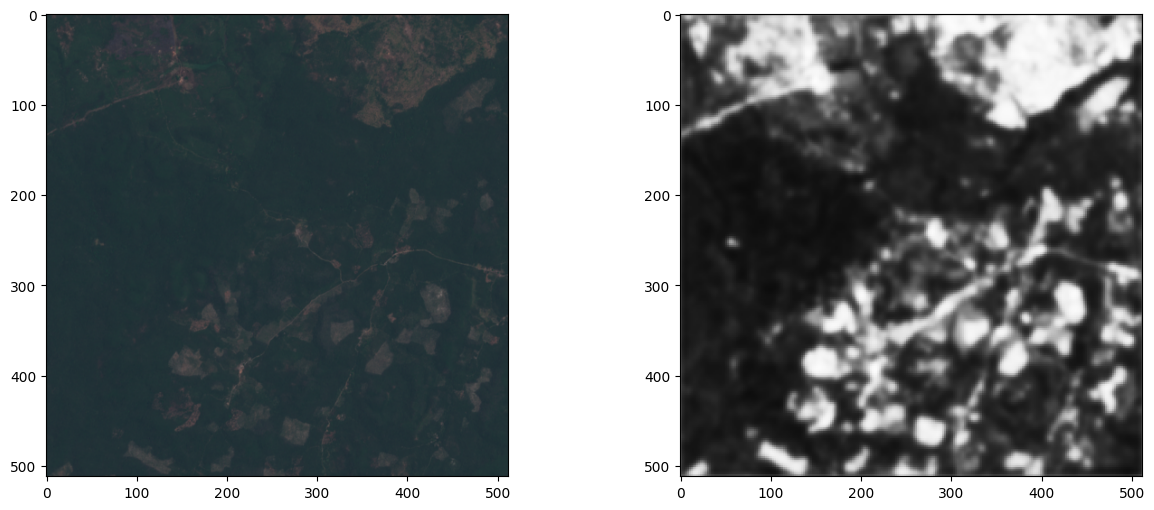

In [7]:
image = PIL.Image.open(r"./data/test/{}".format(test_images_list[1]))
# mask = PIL.Image.open(r"./data/testing/masks/{}".format(test_images_list[0][:-5]+'.png'))

predicted = saved_model.predict(test_images[1])
mask_image = Image.fromarray(predicted[0, :, :, 0] * 255)

fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].imshow(image)
axs[1].imshow(mask_image, cmap='gray')


### U-Net

In [10]:
from UNet import UNet

input_shape = (512, 512, 3)
inputs = Input(input_shape, batch_size=1)

uNetModel = UNet(inputs)

uNetModel.compile(optimizer = adam_v2.Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])
uNetModel.summary()

Model: "u_net_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(1, 512, 512, 3)]   0           []                               
                                                                                                  
 conv2d_24 (Conv2D)             (1, 512, 512, 64)    1792        ['input_3[0][0]']                
                                                                                                  
 activation_19 (Activation)     (1, 512, 512, 64)    0           ['conv2d_24[0][0]']              
                                                                                                  
 conv2d_25 (Conv2D)             (1, 512, 512, 64)    36928       ['activation_19[0][0]']          
                                                                                            

In [14]:
uNetModel.fit(training_images, training_masks, epochs=10, batch_size=1)

uNetModel.save('models/u-net/model')
saved_unet = tf.keras.models.load_model('models/u-net/model')
saved_unet.summary()

Epoch 1/10
75/75 [==============================] - 490s 7s/step - loss: 0.3869 - accuracy: 0.8419 - mse: 0.1258
Epoch 2/10
75/75 [==============================] - 485s 6s/step - loss: 0.2021 - accuracy: 0.9296 - mse: 0.0541
Epoch 3/10
75/75 [==============================] - 481s 6s/step - loss: 0.1886 - accuracy: 0.9304 - mse: 0.0528
Epoch 4/10
75/75 [==============================] - 512s 7s/step - loss: 0.2014 - accuracy: 0.9290 - mse: 0.0566
Epoch 5/10
12/75 [===>..........................] - ETA: 7:25 - loss: 0.1600 - accuracy: 0.9389 - mse: 0.0458

In [ ]:
image = PIL.Image.open(r"./data/test/{}".format(test_images_list[1]))
# mask = PIL.Image.open(r"./data/testing/masks/{}".format(test_images_list[0][:-5]+'.png'))

predicted = saved_unet.predict(test_images[1])
mask_image = Image.fromarray(predicted[0, :, :, 0] * 255)

fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].imshow(image)
axs[1].imshow(mask_image, cmap='gray')
